This files contains an example of tuning a Random Forest model with BayesSearchCV

It saves the BayesSearchCV object to the `cross-validation.pkl`

In [41]:
import pickle
import helpsk as hlp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

%matplotlib inline

# Load Data

In [42]:
with open('../X_train.pkl', 'rb') as handle:
    X_train = pickle.load(handle)

with open('../y_train.pkl', 'rb') as handle:
    y_train = pickle.load(handle)

In [43]:
hlp.pandas.numeric_summary(X_train, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
duration,760,40,5.0%,0,0.0%,21.0,11.7,0.6,1.0,0.6,4.0,9.0,12.0,18.0,24.0,36.0,60.0
credit_amount,800,0,0.0%,38,5.0%,"3,203.9","2,932.3",0.9,1.9,3.9,0.0,753.9,"1,300.8","2,236.5","3,951.5","7,394.6","18,424.0"
installment_commitment,800,0,0.0%,0,0.0%,3.0,1.1,0.4,-0.5,-1.2,1.0,1.0,2.0,3.0,4.0,4.0,4.0
residence_since,800,0,0.0%,0,0.0%,2.9,1.1,0.4,-0.3,-1.4,1.0,1.0,2.0,3.0,4.0,4.0,4.0
age,800,0,0.0%,0,0.0%,35.6,11.4,0.3,1.0,0.7,19.0,23.0,27.0,33.0,42.0,52.0,75.0
existing_credits,800,0,0.0%,0,0.0%,1.4,0.6,0.4,1.3,1.6,1.0,1.0,1.0,1.0,2.0,2.0,4.0
num_dependents,800,0,0.0%,0,0.0%,1.1,0.3,0.3,2.0,2.1,1.0,1.0,1.0,1.0,1.0,2.0,2.0


In [44]:
hlp.pandas.non_numeric_summary(X_train, return_style=True)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
checking_status,763,37,4.6%,no checking,4,0.5%
credit_history,800,0,0.0%,existing paid,5,0.6%
purpose,800,0,0.0%,radio/tv,10,1.2%
savings_status,800,0,0.0%,<100,5,0.6%
employment,800,0,0.0%,1<=X<4,5,0.6%
personal_status,800,0,0.0%,male single,4,0.5%
other_parties,800,0,0.0%,none,3,0.4%
property_magnitude,800,0,0.0%,car,4,0.5%
other_payment_plans,800,0,0.0%,none,3,0.4%
housing,800,0,0.0%,own,3,0.4%


In [45]:
y_train[0:10]

array([0, 0, 1, 0, 1, 0, 1, 0, 0, 1])

In [46]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([241, 559]))

In [47]:
np.unique(y_train, return_counts=True)[1] / np.sum(np.unique(y_train, return_counts=True)[1])

array([0.30125, 0.69875])

# Transformation Pipeline

In [48]:
from sklearn.preprocessing import OrdinalEncoder
OrdinalEncoder().fit_transform(X_train[['purpose', 'savings_status']])

array([[0., 2.],
       [2., 2.],
       [9., 1.],
       ...,
       [9., 3.],
       [6., 4.],
       [6., 2.]])

In [49]:
numeric_columns = hlp.pandas.get_numeric_columns(X_train)
non_numeric_columns = hlp.pandas.get_non_numeric_columns(X_train)
print(numeric_columns)
print(non_numeric_columns)

['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']


In [50]:
numeric_pipeline = Pipeline([
    #tune whether or not we want to impute or simply remove rows with missing values
    ('impute', hlp.sklearn_pipeline.TransformerChooser()),
    # this is here so that we can select between MinMax and Scaler
    # if this pipeline is ran in a context outside of tuning, no transformation will take place
    ('scaling', hlp.sklearn_pipeline.TransformerChooser()),
])

In [51]:
non_numeric_pipeline = Pipeline([
    ('encoder', hlp.sklearn_pipeline.TransformerChooser()),
])

In [52]:
from sklearn.compose import ColumnTransformer
transformations_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('non_numeric', non_numeric_pipeline, non_numeric_columns)
])

# Model

In [53]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42)

In [54]:
full_pipeline = Pipeline([
    ('prep', transformations_pipeline),
    ('model', random_forest_model)
])

In [55]:
# Show the levels of pipelines/transformers/model
full_pipeline.named_steps

{'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('impute',
                                                   TransformerChooser()),
                                                  ('scaling',
                                                   TransformerChooser())]),
                                  ['duration', 'credit_amount',
                                   'installment_commitment', 'residence_since',
                                   'age', 'existing_credits',
                                   'num_dependents']),
                                 ('non_numeric',
                                  Pipeline(steps=[('encoder',
                                                   TransformerChooser())]),
                                  ['checking_status', 'credit_history',
                                   'purpose', 'savings_status', 'employment',
                                   'personal_status', 'other_parties',
     

# GridSearchCV

In [56]:
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score  # , roc_auc_score
from sklearn.metrics import SCORERS

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# https://stackoverflow.com/questions/60615281/different-result-roc-auc-score-and-plot-roc-curve
scores = {
    # https://github.com/scikit-learn/scikit-learn/blob/2beed5584/sklearn/metrics/_scorer.py#L537
    'ROC/AUC':  SCORERS['roc_auc'],
    'F1': make_scorer(f1_score, greater_is_better=True),
    'Pos. Pred. Val': make_scorer(precision_score, greater_is_better=True),
    'True Pos. Rate': make_scorer(recall_score, greater_is_better=True),
}

In [57]:
param_grad = [
    {
        'prep__numeric__impute__transformer': [SimpleImputer(strategy='mean')],
        'prep__numeric__scaling__transformer': [MinMaxScaler(), StandardScaler()],
        'prep__non_numeric__encoder__transformer': [OneHotEncoder(),
                                                    hlp.sklearn_pipeline.CustomOrdinalEncoder()],
        'model__max_features': [2, 10, 'auto'],
        'model__n_estimators': [50, 100, 500]
    },
]

In [58]:
num_folds = 5
num_repeats = 2

In [59]:
new_param_column_names = {'model | max_features': 'max_features',
                          'model | n_estimators': 'n_estimators',
                          'prep | non_numeric | encoder | transformer': 'encoder',
                          'prep | numeric | impute | transformer': 'imputer',
                          'prep | numeric | scaling | transformer': 'scaler'}

In [60]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(full_pipeline,
                           param_grid=param_grad,
                           cv=RepeatedKFold(n_splits=num_folds,
                                            n_repeats=num_repeats,
                                            random_state=2),
                           scoring=scores,
                           refit='ROC/AUC',
                           #scoring='roc_auc',
                           return_train_score=True
                           )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=2, n_splits=5, random_state=2),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('impute',
                                                                                          TransformerChooser()),
                                                                                         ('scaling',
                                                                                          TransformerChooser())]),
                                                                         ['duration',
                                                                          'credit_amount',
                                                                          'installment_commitment',
                                                                          'residence_since

In [70]:
print(grid_search.cv_results_)

{'mean_fit_time': array([0.21950977, 0.13447182, 0.1441529 , 0.07360697, 0.11029053,
       0.10768032, 0.21327944, 0.27018371, 0.74392893, 1.00881407,
       0.81646128, 1.1857296 , 0.08138123, 0.0734973 , 0.10358696,
       0.16368606, 0.3521528 , 0.39671016, 0.37484214, 0.61681886,
       2.19434097, 0.98685784, 1.84156377, 1.4716146 , 0.54971724,
       0.08778632, 0.08032196, 0.10242209, 0.16960328, 0.27238629,
       0.28444185, 0.1537884 , 0.64355445, 0.61625593, 0.57109137,
       0.53922842]), 'std_fit_time': array([0.08349742, 0.01577237, 0.07527884, 0.00459968, 0.00720648,
       0.00654425, 0.08438533, 0.02780355, 0.35448561, 0.32716557,
       0.33475202, 0.35812527, 0.00507889, 0.00302111, 0.0069314 ,
       0.05296206, 0.04044515, 0.08663239, 0.13695489, 0.41447897,
       1.15901491, 0.43081465, 0.72311275, 0.62709372, 0.53736742,
       0.01827482, 0.00687049, 0.02099179, 0.04179248, 0.25434971,
       0.17368878, 0.02967505, 0.07818656, 0.07606209, 0.06009813,
       

In [62]:
grid_search.cv

RepeatedKFold(n_repeats=2, n_splits=5, random_state=2)

## Results

In [63]:
print(grid_search.cv.n_repeats)
print(grid_search.cv.cvargs['n_splits'])

2
5


In [64]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.771524602897316
{'model__max_features': 2, 'model__n_estimators': 500, 'prep__non_numeric__encoder__transformer': OneHotEncoder(), 'prep__numeric__impute__transformer': SimpleImputer(), 'prep__numeric__scaling__transformer': MinMaxScaler()}


In [65]:
new_param_column_names

{'model | max_features': 'max_features',
 'model | n_estimators': 'n_estimators',
 'prep | non_numeric | encoder | transformer': 'encoder',
 'prep | numeric | impute | transformer': 'imputer',
 'prep | numeric | scaling | transformer': 'scaler'}

In [66]:
grid_search_parsed = hlp.sklearn_eval.SearchCVParser(searcher=grid_search,
                                                     higher_score_is_better = True,
                                                     new_param_column_names=new_param_column_names)

In [1]:
grid_search_parsed.formatted_results()

NameError: name 'grid_search_parsed' is not defined

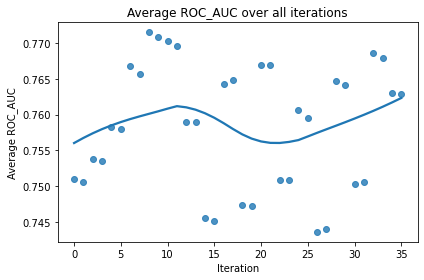

In [68]:
sns.regplot(x=np.arange(0, len(grid_search_parsed.results)), y=grid_search_parsed.results.sort_index()['ROC/AUC Mean'], lowess=True)
plt.title("Average ROC_AUC over all iterations")
plt.ylabel("Average ROC_AUC")
plt.xlabel("Iteration")
plt.tight_layout()

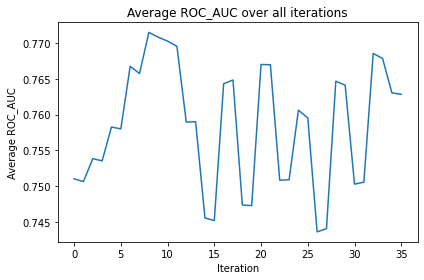

In [69]:
grid_search_parsed.results.sort_index()['ROC/AUC Mean'].plot()
plt.title("Average ROC_AUC over all iterations")
plt.ylabel("Average ROC_AUC")
plt.xlabel("Iteration")
plt.tight_layout()